# How to use this Script
This doc goes through the analysis in Excelsior Paper. We are analyzing cursor dyanmics as a time sereis and use multiple different methods to explore the potential of this data. below are the initial instruction and further instruction for each stage will be presented at that stage. GLHF.

First we have to install and import the required libraries in the lext two cells. Next we prep import and prep the data converting some string columns to int and select our time series feature of interest. The defualt is set to accelerations though the other options are listed in the appropriate cell. From there any individual analysis can be run seperately and will end with a scatter plot of the results. Here we use primarily visual analysis of the results because our varying methods sometimes require varying methods for measuring accuracy that are not directly comparable but the visua interpretationsare still comparable.

## Import libraries

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
import matplotlib.pyplot as plt
import matplotlib.font_manager
# import nolds
import seaborn as sns
import statsmodels.api as sm
import scipy

In [ ]:
plt.figure(figsize=(8,16))

<Figure size 576x1152 with 0 Axes>

<Figure size 576x1152 with 0 Axes>

### Import and Prep Data

In [ ]:
# Import the data
df_Feb = pd.read_pickle("https://mymousetrackingdatabucket.s3-us-west-1.amazonaws.com/data/game_data_300_feb_O.p")

df_Jan = pd.read_pickle("https://mymousetrackingdatabucket.s3-us-west-1.amazonaws.com/data/game_data_300_jan_O.p")

In [ ]:
# To give a sense of what we have available
# Many of these cells have whole time series in them.
# Rows are participants, columns are these features (raw data is not here)
df_Feb.columns

Index(['ID', 'device', 'accratio', 'Xcord', 'Ycord', 'Timemousecords',
       'timestimsarrive', 'difficultylevel', 'stimspeed', 'stimsclicked',
       'stimsshown', 'mouseCordsYClicks', 'mouseCordsXClicks', 'clicktimes',
       'Q1', 'Q2', 'Q3', 'Age', 'CatchQ1', 'CatchQ2', 'Gender', 'NumPoints',
       'Timemousecordso', 'VG_growing', 'VG_now', 'Xcordo', 'Ycordo',
       'totalNumPoints', 'velocities', 'SmVelocities', 'accelerations',
       'jerks', 'paths', 'deviations', 'pathlen', 'BinaryEng',
       'mean_accelerations', 'var_accelerations', 'mean_velocities',
       'var_velocities', 'mean_sm_velocities', 'var_sm_velocities',
       'mean_jerks', 'var_jerks', 'mean_deviations', 'var_deviations',
       'mean_path_length', 'var_path_length'],
      dtype='object')

In [ ]:
# Pickle format converts numeric to str so we convert the necessary variables back to numeric
df_Feb['Q1int']         = pd.to_numeric(df_Feb.Q1) # Reported Engagement
df_Feb['Q2int']         = pd.to_numeric(df_Feb.Q2) # Reported Difficulty
df_Feb['Q3int']         = pd.to_numeric(df_Feb.Q3) # Reported Fun
df_Feb['dlevel']        = pd.to_numeric(df_Feb.difficultylevel) # Actual difficulty
df_Feb['acr']           = pd.to_numeric(df_Feb.accratio) # Actual performance
df_Feb['stimspeed_num'] = pd.to_numeric(df_Feb.stimspeed) # Numeric stimulus speed
df_Feb['Age']           = pd.to_numeric(df_Feb.Age)

df_Jan['Q1int']         = pd.to_numeric(df_Jan.Q1) # Reported Engagement
df_Jan['Q2int']         = pd.to_numeric(df_Jan.Q2) # Reported Difficulty
df_Jan['Q3int']         = pd.to_numeric(df_Jan.Q3) # Reported Fun
df_Jan['dlevel']        = pd.to_numeric(df_Jan.difficultylevel) # Actual difficulty
df_Jan['acr']           = pd.to_numeric(df_Jan.accratio) # Actual performance
df_Jan['stimspeed_num'] = pd.to_numeric(df_Jan.stimspeed) # Numeric stimulus speed
df_Jan['Age']           = pd.to_numeric(df_Jan.Age)

# Interpolation

In [ ]:
#get the length of longest timeseries
longestT = max(max(df_Feb.apply(lambda row: pd.to_datetime(row['Timemousecordso'][-1], unit='ms') - pd.to_datetime(row['Timemousecordso'][0], unit='ms'), axis=1)), max(df_Jan.apply(lambda row: pd.to_datetime(row['Timemousecordso'][-1], unit='ms') - pd.to_datetime(row['Timemousecordso'][0], unit='ms'), axis=1)))

In [ ]:
def myInterpFunc(Xcords, Ycords, times, desiredT):
# def myInterpFunc(Xcords, Ycords, times):

  tempdf = pd.DataFrame(np.asarray([Xcords, Ycords]).T,pd.to_datetime(times, unit='ms'),['Xcord', 'Ycord'])
  tempdf = tempdf.reset_index().drop_duplicates(subset='index', keep='last').set_index('index').sort_index()
  tempresampled = tempdf.resample("20L").pad()
  # tempresampled = tempresampled.resample("10L").interpolate('time')
  # tempresampled = tempdf.resample("10L").interpolate(method='polynomial', order=2)

  tempresampled.dropna(inplace=True)

  # tempresampled=tempresampled.reindex(pd.date_range(start = tempresampled.index[0], end=(tempresampled.index[0] + desiredT),freq='20L'), method='nearest')

  return [np.asarray(tempresampled.Xcord), np.asarray(tempresampled.Ycord), np.asarray(tempresampled.index)]

In [ ]:
df_Jan[['iXcords','iYcords','itimes']] = df_Jan.apply(lambda row: myInterpFunc(row['Xcordo'],row['Ycordo'],row['Timemousecordso'], longestT), axis=1, result_type='expand')
df_Feb[['iXcords','iYcords','itimes']] = df_Feb.apply(lambda row: myInterpFunc(row['Xcordo'],row['Ycordo'],row['Timemousecordso'], longestT), axis=1, result_type='expand')

# create Complex Cords 

In [ ]:
def CartesiantoComplexCords(Xs, Ys):
  return np.asarray(Xs) + 1j*np.asarray(Ys)

In [ ]:
df_Feb['Ccords'] = df_Feb.apply(lambda row: CartesiantoComplexCords(row['iXcords'],row['iYcords']), axis=1, result_type='reduce')
df_Jan['Ccords'] = df_Jan.apply(lambda row: CartesiantoComplexCords(row['iXcords'],row['iYcords']), axis=1, result_type='reduce')

In [ ]:
def getArcLen(Xs,Ys):
  return np.sum(scipy.spatial.distance.cdist(np.column_stack((Xs,Ys))[:-1], np.column_stack((Xs,Ys))[1:]))

In [ ]:
df_Feb['ArcLen'] = df_Feb.apply(lambda row: getArcLen(row['iXcords'],row['iYcords']), axis=1)
df_Jan['ArcLen'] = df_Jan.apply(lambda row: getArcLen(row['iXcords'],row['iYcords']), axis=1)

## Select the feature for analysis

In [ ]:
#feature we will be trying to predict
outcome = 'acr' #options are 'acr', 'Q1int', 'Q2int', 'Q3int', 'Age'

In [ ]:
#feature we will be analyzing
feature = 'Ccords' #options are jerks, accelerations and velocities, Ccords
#if uusing Ccords use cfft function

## Transform into Frequency Domain
Necessary for powerlaw, SVD, and DFA analyses but can be ignored if not performing those analyses

In [ ]:

# Returns the FFT on one time series, i.e. one 1-dimensional array ordered by time.  
# This can be x's, y's, velocities (based on Euclidean distance between 2d points), acceleratons jerks, etc.
def get_rfft(timeseries, l):
    timeseries = timeseries[:l]
    ff = np.fft.rfft(timeseries)
    
    return ff    

In [ ]:
# Returns the FFT on one time series, i.e. one 1-dimensional array ordered by time.  
# This can include our complex numbers of position data
def get_fft(timeseries, l):
    timeseries = timeseries[:l]
    ff = np.fft.fft(timeseries)
    
    return ff[1:]   

In [ ]:
# Trim the "feature" time series to be same length and then use fft to create spectra for this feature
minlength  = min(min(df_Feb.apply(lambda row: len(row[feature]), axis=1)), min(df_Jan.apply(lambda row: len(row[feature]), axis=1)))  # length of shortest time series

In [ ]:
df_Feb['Cffts'] = df_Feb.apply(lambda row: get_fft(row['Ccords'],minlength), axis=1, result_type='reduce')
df_Jan['Cffts'] = df_Jan.apply(lambda row: get_fft(row['Ccords'],minlength), axis=1, result_type='reduce')

# **Analyses**

## SVD

In [ ]:
#This is set up for accuracy. Before running another variable you would have to determine appropriate splits (maybe I should add cell for doing that?)

# Split into groups high and low accuracy groups for each sample
JHA = df_Jan.loc[df_Jan['acr']>.505] #High accuracy group from Jan sample
JLA = df_Jan.loc[df_Jan['acr']<.12] #Low accuracy group from Jan sample
FHA = df_Feb.loc[df_Feb['acr']>.505] #High accuracy group from Feb sample
FLA = df_Feb.loc[df_Feb['acr']<.12] #Low accuracy group from Feb sample
    
# Stack the data to convert to matrix form for use in svd
JHAD = np.stack(np.array(JHA.Cffts.values)) # January high accuracy data
JLA2D = np.stack(np.array(JLA.Cffts.values))
FHAD = np.stack(np.array(FHA.Cffts.values))
FLAD = np.stack(np.array(FLA.Cffts.values))

In [ ]:
# Compute SVD for High accuracy group from January sample
U, σ, Vstar = np.linalg.svd( JHAD.T )

Text(0, 0.5, 'Cumulative Variance')

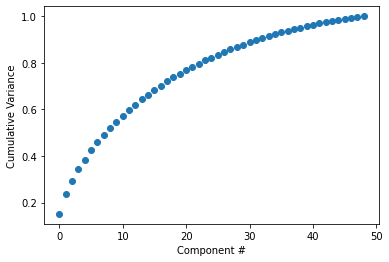

In [ ]:
E = σ ** 2 / np.sum( σ ** 2 )
# plt.scatter(np.E)),E);
plt.scatter(np.arange(len(E)),np.cumsum(E));
plt.xlabel("Component #")
plt.ylabel("Cumulative Variance")
# plt.title("Cumulative Component Plot")

# A cumulative energy plot which show us  how much each principle component 
# is adding to the amount data explained.

# Here 30% of the data is explained by the first component, and 50% by first three
# Suggest the first two components are important in capturing the general structure
# The rest capture something closer to individual people

In [ ]:
# Here we determine k which is the number of principle component to use for reconstruction. 
# If we set ksize = 1 we would just use all of the principle components

ksize = .5 
k = np.min( np.where( np.cumsum(E) >= ksize ) )

# One could alternatively hard set k to a partiuclat interger amount of components to use. 
# For example the first two component contribute the most by far so we could set k to 2
# k = 2
print(k)

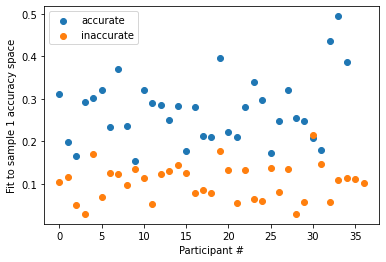

In [ ]:
# Compute reconstruction of the febuary high and low accuracy groups data in 
# the January high accuracy group's space

group  = FHAD
group2 = FLAD
fitsT = U[:,:k] @ (np.conj( U[:,:k] ).T @ group.T)
fitsT2 = U[:,:k] @ (np.conj( U[:,:k] ).T @ group2.T)

ηT = np.full( (1, group.shape[0]), 'nan', dtype = 'float' )
for i in range(0,group.shape[0]):
    ηT[0,i] = np.linalg.norm( fitsT[:,i] ) ** 2 / np.linalg.norm( group.T[:,i] ) ** 2

ηT2 = np.full( (1, group2.shape[0]), 'nan', dtype = 'float' )
for i in range(0,group2.shape[0]):
    ηT2[0,i] = np.linalg.norm( fitsT2[:,i] ) ** 2 / np.linalg.norm( group2.T[:,i] ) ** 2

plt.scatter(np.arange(ηT.shape[1]),ηT, label = "Accurate");
plt.scatter(np.arange(ηT2.shape[1]),ηT2, label = "Inaccurate");
plt.xlabel("Participant #")
plt.ylabel("Fit to Sample 1 Accuracy Space")
plt.legend()

# Here the value on the Y axis is the amount of the data that is able to be 
# reconstructed from the january groups principle components

# The result we've had from the start; shows we could build a good classifer
# stats.ttest_ind(ηT,ηT2,equal_var=False)

Text(0.5, 0, 'Fit to Jan. accuracy space')

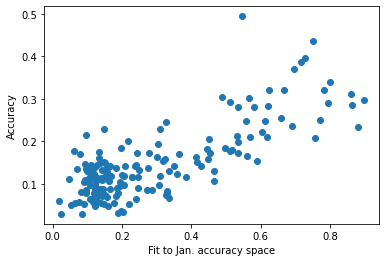

In [ ]:
# Compute reconstruction of full febuary sample in January's accuracy player space

All = np.stack(np.array(df_Feb.Cffts.values))
FitsAll = U[:,:k] @ (np.conj( U[:,:k] ).T @ All.T)
ηAll = np.full( (1, All.shape[0]), 'nan', dtype = 'float' )
for i in range(0,All.shape[0]):
    ηAll[0,i] = np.linalg.norm( FitsAll[:,i] ) ** 2 / np.linalg.norm( All.T[:,i] ) ** 2

df_Feb['Etas'] = ηAll.T

sns.lmplot(x='acr',y='Etas', data=df_Feb,fit_reg=True, aspect=1.5)
plt.xlabel("Participant Performance")
plt.ylabel("Participant fit to Jan High Performer Space")
plt.title("Similarity to Higher Performers Regressed on Actual Performance")

slope, intercept, r_value, pv, se = stats.linregress(df_Feb.acr.values,ηAll)
print(pv)
#in this plot accuracy of participant is on the X axis and the Y axis is the participants fit to the highly accurate players from the january group
# May suggest three types of player: low, middling, and high accuracy


In [ ]:
r_value * r_value

0.6067966604344319

## Look at loglog structure

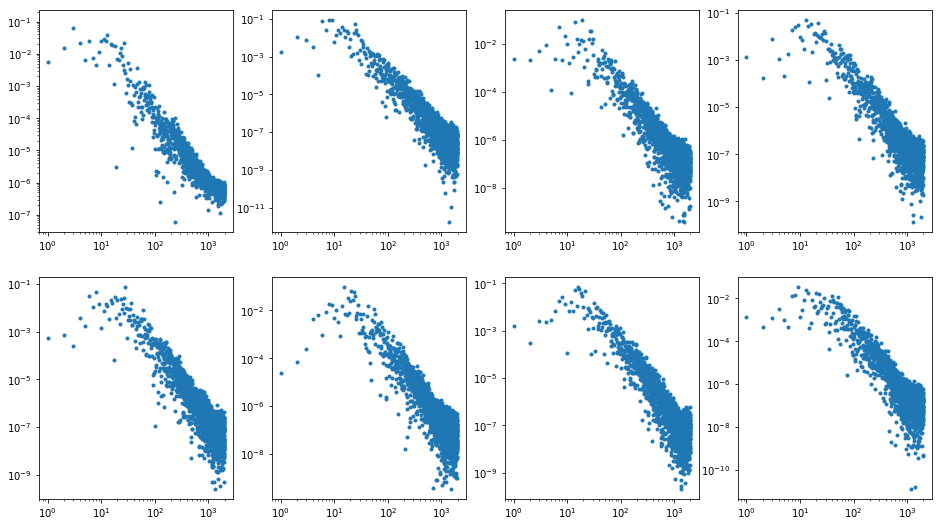

In [ ]:
plt.rcParams['figure.figsize'] = [16,9]

for i in range (0,8):
  plt.subplot(2,4,i+1)
  plt.loglog(np.abs(U[:1963,i]**2),'.')

Text(0.5, 0, 'log of Power')

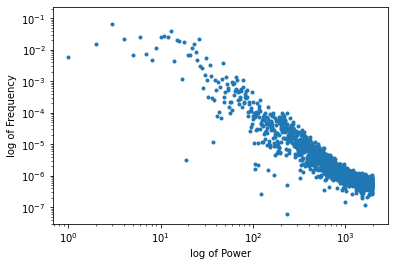

In [ ]:
plt.loglog(abs(U[:1963,0]**2),'.')
plt.ylabel("log of Frequency")
plt.xlabel("log of Power")
# plt.title("log-log Plot of Most Important Component")


## DFA

In [ ]:
def getWalk(values):
  wValues = np.cumsum(values - np.mean(values))
  return wValues

In [ ]:
def getScales(minN, N, winRatio=1.2):

  # maxW = int(np.floor(N/minN))
  maxW = 0.1 * N
  numscales = int(np.floor(np.log(1.0 * maxW / minN) / np.log(winRatio) + 1))

  scales = []

  for i in range(1,numscales,1):
    scales.append(int(np.floor(minN * (winRatio**i))))
  
  return(scales)


In [ ]:
def getResiduals(times, values):
  A = np.vstack([times, np.ones(len(times))]).T
  line, res, rank, s = np.linalg.lstsq(A, values)
  return values - (A @ line)

In [ ]:
def getWindows(series,windowsize,overlap):

  # myindex = np.arange(0,((len(series)-windowsize)/windowsize*overlap + 1) * windowsize,1)

  # c_len_index = np.floor((len(series)-windowsize) / (windowsize*overlap))*windowsize + windowsize

  # myindex = np.hstack([myindex,np.arange(len(myindex),c_len_index,1)]) 

  myindex = np.arange(0,(np.floor((len(series)-windowsize) / np.floor(windowsize*overlap))*windowsize + windowsize), 1)

  numwindows = int(len(myindex)/windowsize)

  myindex = myindex.reshape(numwindows,windowsize).astype(int)

  adjusterarray = np.asarray(np.ones((windowsize,numwindows)) * np.arange(0,numwindows,1)).astype(int).T * int(windowsize - np.floor(windowsize*overlap))

  myindex = myindex - adjusterarray
  
  return myindex

In [ ]:
def cDFA(values):
  #convert to walk
  wValues = getWalk(values)

  #getScales args are mins scale, number of sampels, and option spacer 
  Scales = getScales(4, len(wValues))

  #array to store fluctuation vlaues
  Fs = []

  for scale in Scales:
    #for each scale we now need ot get the actual windowed time series
    windows = getWindows(wValues, scale, .5)

    #an object to store root mean square values
    w_RMSE = []

    x = np.arange(scale)

    for i in range(0,len(windows)):

      #get the residuals around a local trend for calculating
      residuals = getResiduals(x,wValues[windows[i]])
  
      #get by just squaring the residuals, taking the mwan of that an then square rooting that
      rmse = np.sqrt((np.conj(residuals).T @ residuals ) / len(residuals))
      w_RMSE.append(rmse)

    Fs.append(np.asarray(w_RMSE).mean())

  logFs = np.log(Fs)
  logScales = np.log(Scales)

  #calulate hurst param by fitting line to logscaled Fs and log scaled scale sizes
  H, res, rank, s = np.linalg.lstsq(np.vstack([logScales, np.ones(len(logScales))]).T, logFs)

  return H[0] #, Fs, Scales, poly[0], np.polyfit(logScales, logFs, 1), 

In [ ]:
df_Feb['Hs'] = df_Feb.apply(lambda row: cDFA(row['Ccords']), axis=1, result_type='reduce')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [ ]:
df_Feb['absHs'] = df_Feb.apply(lambda row: abs(row['Hs']), axis=1)

-0.7502726716938489 0.00015518900545460803


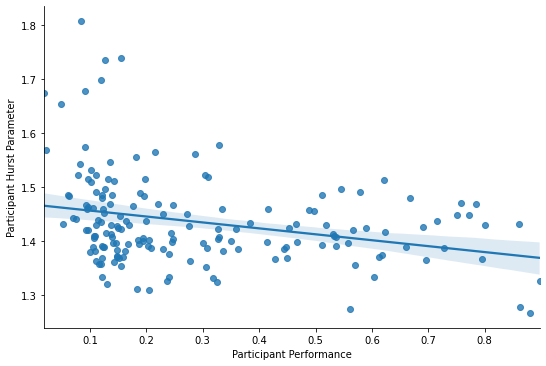

In [ ]:
sns.lmplot(x='acr',y='absHs',data=df_Feb,fit_reg=True, aspect=1.5);
plt.ylabel("Participant Hurst Parameter")
plt.xlabel("Participant Performance")
# plt.title("Hurst Parameters regressed on Performance")
slope, intercept, r_value, pv, se = stats.linregress(df_Feb.absHs.values,df_Feb.acr.values)
print(slope, pv)

In [ ]:
slope

-0.7502726716938489

In [ ]:
se

0.19381376240732864

In [ ]:
r_value * r_value

0.0823440884649697